![](image_2.png)

# Business case study : Product Sales Forecasting 



**Business Problem-**

        Accurate sales forecasting is essential for operational and strategic planning in the fiercely competitive 
        
        retail sector. With the help of a variety of influencing variables, including business type, location, 
        
        regional traits, promotional activities, and temporal fluctuations (such holidays and seasons), 
        
        product sales forecasting seeks to predict how many products a store will sell in the future. 
        
        In order to forecast sales for future periods, this project focuses on building a predictive model that 
        
        utilizes previous sales data from various stores.

        

_**Importing Python Libraries necessary while carrying out data exploration & visualisation**_ -
    


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder   # Label Encoder
from sklearn.preprocessing import StandardScaler  # Standard Scaling

from sklearn.model_selection import train_test_split   # train_test_split
from sklearn.model_selection import KFold, cross_validate


## Bagging - Random Forest
from sklearn.ensemble import RandomForestClassifier   # RF Classifier
from sklearn.model_selection import GridSearchCV   # Grid search


# ACF & PACF (Auto correlation and Partial Auto Correlation)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA Function -
from statsmodels.tsa.arima.model import ARIMA

# SARIMAX Function
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Seasonal Decompose -
from statsmodels.tsa.seasonal import seasonal_decompose

# from prophet import Prophet

_**Upload & read csv file in pandas dataframe**_ -
    

In [76]:
df_train = pd.read_csv("TRAIN.csv")
df_test = pd.read_csv("TEST_FINAL.csv")

In [77]:
df_train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [19]:
df_train.tail()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41
188339,T1188340,152,S2,L1,R1,2019-05-31,1,No,47,37977.00


In [78]:
df_test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


-----------

In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


    Comments -
    
        No null values present in the dataset.
        

    Let's Drop some unwanted columns -
    

In [80]:
df_train.drop(['ID'],axis = 1,inplace = True)
df_test.drop(['ID'],axis = 1,inplace = True)

In [8]:
df_train.describe()

,Store_id,Holiday,#Order,Sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


In [9]:
df_train.describe(include = "object")

,Store_Type,Location_Type,Region_Code,Date,Discount
count,188340,188340,188340,188340,188340
unique,4,5,4,516,2
top,S1,L1,R1,2018-01-01,No
freq,88752,85140,63984,365,104051



------

In [81]:
# Change the datatype of date
df_train['Date'] = pd.to_datetime(df_train.Date)

------

    **Time Series Analysis -
    

In [82]:
df_train.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [83]:
df_train_time = df_train.groupby('Date')["Sales"].sum().reset_index()

In [84]:
df_train_time.head()

,Date,Sales
0,2018-01-01,15345484.5
1,2018-01-02,19592415.0
2,2018-01-03,18652527.0
3,2018-01-04,19956267.0
4,2018-01-05,22902651.0


In [85]:
result = sm.tsa.seasonal_decompose(df_train_time['Sales'].values, model = 'additive', period = 7)

<Figure size 640x480 with 0 Axes>

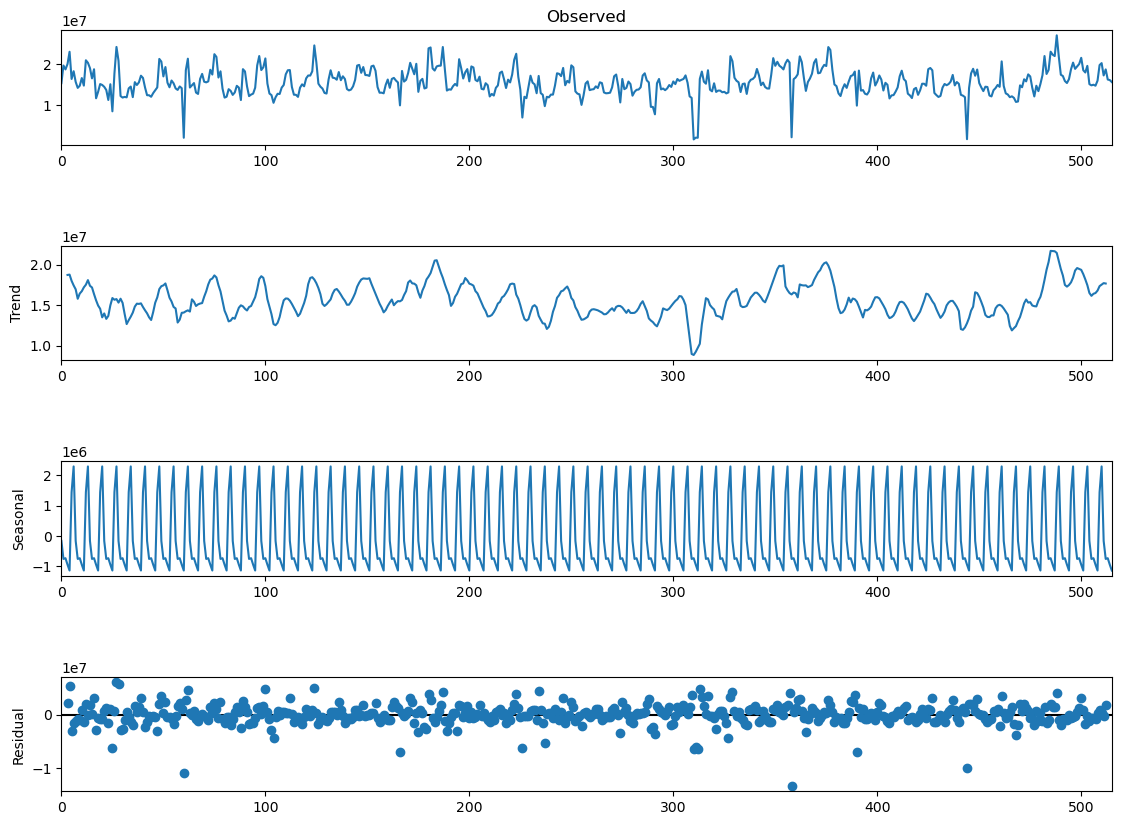

In [86]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
fig.show()


-------

    Let's drop orders column as it is highly correlated. 


In [87]:
df_train.drop(['#Order'],axis=1,inplace=True)

----

## Block 3 ML Modeling

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store_id       188340 non-null  int64         
 1   Store_Type     188340 non-null  object        
 2   Location_Type  188340 non-null  object        
 3   Region_Code    188340 non-null  object        
 4   Date           188340 non-null  datetime64[ns]
 5   Holiday        188340 non-null  int64         
 6   Discount       188340 non-null  object        
 7   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 11.5+ MB


    Before moving ahead with model building, we will do some feature engineering to create different features,
    
    such as year, month, day, weekday, etc..
    

In [89]:
# Date
import datetime as dt

df_train[['Date']] = df_train[['Date']].astype(object)

In [90]:
train_date_lst = []
train_year_date_lst = []
train_month_date_lst = []
train_day_date_lst = []
train_weekday_date_lst = []

for d in df_train['Date']:
  train_date_lst.append(d.to_pydatetime())

for year in train_date_lst:
  train_year_date_lst.append(year.strftime('%Y'))

for month in train_date_lst:
  train_month_date_lst.append(month.strftime('%m'))

for day in train_date_lst:
  train_day_date_lst.append(day.strftime('%d'))

for weekday in train_date_lst:
  train_weekday_date_lst.append(weekday.strftime('%A'))

In [91]:
df_train['Year'] = pd.Series(train_year_date_lst)
df_train['Month'] = pd.Series(train_month_date_lst)
df_train['Day'] = pd.Series(train_day_date_lst)
df_train['Week Day'] = pd.Series(train_weekday_date_lst)

In [92]:
df_train.drop(['Date'],axis=1,inplace=True)
df_train.head()

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,Year,Month,Day,Week Day
0,1,S1,L3,R1,1,Yes,7011.84,2018,01,01,Monday
1,253,S4,L2,R1,1,Yes,51789.12,2018,01,01,Monday
2,252,S3,L2,R1,1,Yes,36868.20,2018,01,01,Monday
3,251,S2,L3,R1,1,Yes,19715.16,2018,01,01,Monday
4,250,S2,L3,R4,1,Yes,45614.52,2018,01,01,Monday


    Data Transformation (Encoding) -
    
        Here, we will use label encoding Technique, as we have ordinal type of features.

In [93]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [94]:
df_train['Store_Type'] = encoder.fit_transform(df_train['Store_Type'])
df_train['Location_Type'] = encoder.fit_transform(df_train['Location_Type'])
df_train['Region_Code'] = encoder.fit_transform(df_train['Region_Code'])
df_train['Discount'] = encoder.fit_transform(df_train['Discount'])
df_train['Week Day'] = encoder.fit_transform(df_train['Week Day'])

In [95]:
df_train.head()

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,Year,Month,Day,Week Day
0,1,0,2,0,1,1,7011.84,2018,01,01,1
1,253,3,1,0,1,1,51789.12,2018,01,01,1
2,252,2,1,0,1,1,36868.20,2018,01,01,1
3,251,1,2,0,1,1,19715.16,2018,01,01,1
4,250,1,2,3,1,1,45614.52,2018,01,01,1


     Now, we will create holidays in year & months, Discounts in year and month, etc features.
     

In [96]:
df_train.groupby(['Year','Holiday'])['Store_id'].count()

Year  Holiday
2018  0          116070
      1           17155
2019  0           47450
      1            7665
Name: Store_id, dtype: int64

In [97]:
df_train['Holidays in Year'] = df_train.groupby(['Year','Holiday'])['Store_id'].transform('count')

In [98]:
df_train.groupby(['Month','Holiday'])['Store_id'].count()

Month  Holiday
01     0          18980
       1           3650
02     0          18615
       1           1825
03     0          18980
       1           3650
04     0          17885
       1           4015
05     0          21170
       1           1460
06     0          10220
       1            730
07     0          10950
       1            365
08     0           9490
       1           1825
09     0           9855
       1           1095
10     0           8760
       1           2555
11     0           8030
       1           2920
12     0          10585
       1            730
Name: Store_id, dtype: int64

In [99]:
df_train['Holidays in Month'] = df_train.groupby(['Month','Holiday'])['Store_id'].transform('count')

In [100]:
df_train.groupby(['Year','Discount'])['Store_id'].count()

Year  Discount
2018  0           72321
      1           60904
2019  0           31730
      1           23385
Name: Store_id, dtype: int64

In [101]:
df_train['Dicounts in Year'] = df_train.groupby(['Year','Discount'])['Store_id'].transform('count')

In [102]:
df_train.groupby(['Month','Discount'])['Store_id'].count()

Month  Discount
01     0           12285
       1           10345
02     0           12325
       1            8115
03     0           11876
       1           10754
04     0           13918
       1            7982
05     0           11644
       1           10986
06     0            5822
       1            5128
07     0            5940
       1            5375
08     0            5732
       1            5583
09     0            5619
       1            5331
10     0            5925
       1            5390
11     0            6504
       1            4446
12     0            6461
       1            4854
Name: Store_id, dtype: int64

In [103]:
df_train['Dicounts in Month'] = df_train.groupby(['Month','Discount'])['Store_id'].transform('count')

In [104]:
df_train.head()

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,Sales,Year,Month,Day,Week Day,Holidays in Year,Holidays in Month,Dicounts in Year,Dicounts in Month
0,1,0,2,0,1,1,7011.84,2018,01,01,1,17155,3650,60904,10345
1,253,3,1,0,1,1,51789.12,2018,01,01,1,17155,3650,60904,10345
2,252,2,1,0,1,1,36868.20,2018,01,01,1,17155,3650,60904,10345
3,251,1,2,0,1,1,19715.16,2018,01,01,1,17155,3650,60904,10345
4,250,1,2,3,1,1,45614.52,2018,01,01,1,17155,3650,60904,10345


    Let's change the datatype of newly created columns to int datatype
    

In [105]:
df_train['Year'] = df_train['Year'].astype('int')
df_train['Month'] = df_train['Month'].astype('int')
df_train['Day'] = df_train['Day'].astype('int')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Store_id           188340 non-null  int64  
 1   Store_Type         188340 non-null  int32  
 2   Location_Type      188340 non-null  int32  
 3   Region_Code        188340 non-null  int32  
 4   Holiday            188340 non-null  int64  
 5   Discount           188340 non-null  int32  
 6   Sales              188340 non-null  float64
 7   Year               188340 non-null  int32  
 8   Month              188340 non-null  int32  
 9   Day                188340 non-null  int32  
 10  Week Day           188340 non-null  int32  
 11  Holidays in Year   188340 non-null  int64  
 12  Holidays in Month  188340 non-null  int64  
 13  Dicounts in Year   188340 non-null  int64  
 14  Dicounts in Month  188340 non-null  int64  
dtypes: float64(1), int32(8), int64(6)
memory usage: 15.

    Train - test split -
    
        Let's do train and test split along with normalization.
        

In [106]:
train_X = df_train.drop(['Sales'],axis=1)
train_Y = df_train['Sales']

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [108]:
scaled_train_X = scaler.fit_transform(train_X)

In [109]:
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(scaled_train_X, train_Y, test_size = 0.25, random_state = 42)

    **Linear Regression Model -
    

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
from sklearn.linear_model import LinearRegression
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [88]:
param_grid_lr = {
    'copy_X': [True, False],              
    'fit_intercept': [True, False],
}

grid_lr = GridSearchCV(LinearRegression(), param_grid_lr, refit = True, verbose = 3, n_jobs = -1)
grid_lr.fit(X_train, Y_train)

print('\n')
Y1_train_pred = grid_lr.predict(X_train)
Y1_valid_pred = grid_lr.predict(X_valid)

print("Train Accuracy: ",r2_score(Y_train,Y1_train_pred))
print("Validation Accuracy: ",r2_score(Y_valid,Y1_valid_pred))

print('')

print("Train RMSE Error: ",np.sqrt(mean_squared_error(Y_train,Y1_train_pred)))
print("Validation RMSE Error: ",np.sqrt(mean_squared_error(Y_valid,Y1_valid_pred)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Train Accuracy:  0.4348903850828726
Validation Accuracy:  0.43196676736520256

Train RMSE Error:  13894.42257893147
Validation RMSE Error:  13850.4124472943


    Comments -
    
        As we can see that the accuracy is low with huge RMSE Error. We will go for complex models 


    **KNN Model -
    

In [89]:
from sklearn.neighbors import KNeighborsRegressor
KNeighborsRegressor().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [90]:
param_grid_knn = {'n_neighbors':[3,5,11,29],              
              'metric':['euclidean','manhattan'],              
              'weights':['uniform','distance']}  
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, refit = True, verbose = 3,n_jobs = -1) 
grid_knn.fit(X_train,Y_train) 

print('\n')

Y2_train_pred = grid_knn.predict(X_train)
Y2_valid_pred = grid_knn.predict(X_valid)

print("Train Accuracy: ",r2_score(Y_train,Y2_train_pred))
print("Validation Accuracy: ",r2_score(Y_valid,Y2_valid_pred))

print('')

print("Train RMSE Error: ",np.sqrt(mean_squared_error(Y_train,Y2_train_pred)))
print("Validation RMSE Error: ",np.sqrt(mean_squared_error(Y_valid,Y2_valid_pred)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Train Accuracy:  0.7660512397745338
Validation Accuracy:  0.7158139927463234

Train RMSE Error:  8939.938453580167
Validation RMSE Error:  9796.640674926484


    Comments -
    
        Accuracy is somewhat increased upto 76%.
        


    **Decision Tree -

In [91]:
from sklearn.tree import DecisionTreeRegressor
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [92]:
param_grid_dt = {"splitter":["best","random"],
                "max_depth" : [1,5,9,12],
                "min_samples_leaf":[1,3,5,8,10],
                "min_weight_fraction_leaf":[0.1,0.4,0.7,0.9],
                "max_features":["auto","log2","sqrt",None],
                "max_leaf_nodes":[None,10,20,40,70,90] }
grid_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, refit = True, verbose = 3,n_jobs = -1) 
grid_dt.fit(X_train,Y_train) 

print('\n')

Y3_train_pred = grid_knn.predict(X_train)
Y3_valid_pred = grid_knn.predict(X_valid)

print("Train Accuracy: ",r2_score(Y_train,Y3_train_pred))
print("Validation Accuracy: ",r2_score(Y_valid,Y3_valid_pred))

print('')

print("Train RMSE Error: ",np.sqrt(mean_squared_error(Y_train,Y3_train_pred)))
print("Validation RMSE Error: ",np.sqrt(mean_squared_error(Y_valid,Y3_valid_pred)))

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


Train Accuracy:  0.7660512397745338
Validation Accuracy:  0.7158139927463234

Train RMSE Error:  8939.938453580167
Validation RMSE Error:  9796.640674926484


    Comments -
    
        Accuracy is nearly same as the KNN Model.
        


    **Random Forest Model -
    

In [93]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [94]:
param_grid_rf = {"max_depth" : [1,5,9,12],
                "min_samples_leaf":[1,3,5,8,10],
                "min_weight_fraction_leaf":[0.1,0.4,0.7,0.9],
                "max_features":["auto","log2","sqrt"],
                "max_leaf_nodes":[10,20,40,70,90]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, refit = True, verbose = 3, n_jobs = -1, cv = 2) 
grid_rf.fit(X_train,Y_train) 

print('\n')

Y5_train_pred = grid_rf.predict(X_train)
Y5_valid_pred = grid_rf.predict(X_valid)

print("Train Accuracy: ",r2_score(Y_train,Y5_train_pred))
print("Validation Accuracy: ",r2_score(Y_valid,Y5_valid_pred))

print('')

print("Train RMSE Error: ",np.sqrt(mean_squared_error(Y_train,Y5_train_pred)))
print("Validation RMSE Error: ",np.sqrt(mean_squared_error(Y_valid,Y5_valid_pred)))

Fitting 2 folds for each of 1200 candidates, totalling 2400 fits


Train Accuracy:  0.4337140295490157
Validation Accuracy:  0.4329679712096205

Train RMSE Error:  13908.87666297824
Validation RMSE Error:  13838.200836032724


    Comments -
    
        Accuracy is droped again in RF.
        


    **XGBoost -
    

In [96]:
!pip install xgboost

     -------------------------------------- 124.9/124.9 MB 2.6 MB/s eta 0:00:00


In [97]:
from xgboost import XGBRegressor
XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [98]:
param_grid_xb = {
  'max_depth':range(3,10,2),
  'min_child_weight':range(1,6,2),
  'colsample_bytree':[i/10.0 for i in range(6,10)],
  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

grid_xb = GridSearchCV(XGBRegressor(), param_grid_xb, refit = True, verbose = 3, n_jobs = -1, cv = 2) 
grid_xb.fit(X_train,Y_train) 

print('\n')

Y6_train_pred = grid_xb.predict(X_train)
Y6_valid_pred = grid_xb.predict(X_valid)

print("Train Accuracy: ",r2_score(Y_train,Y6_train_pred))
print("Validation Accuracy: ",r2_score(Y_valid,Y6_valid_pred))

print('')

print("Train RMSE Error: ",np.sqrt(mean_squared_error(Y_train,Y6_train_pred)))
print("Validation RMSE Error: ",np.sqrt(mean_squared_error(Y_valid,Y6_valid_pred)))

Fitting 2 folds for each of 240 candidates, totalling 480 fits


Train Accuracy:  0.8820710443647567
Validation Accuracy:  0.8331539760896458

Train RMSE Error:  6347.232124117165
Validation RMSE Error:  7506.435629167132


    Comments -
    
        Accuracy is nearly 88%.
        


In [99]:
grid_xb.best_params_

{'colsample_bytree': 0.6,
 'max_depth': 9,
 'min_child_weight': 3,
 'reg_alpha': 0.05}

In [100]:
xgb = XGBRegressor(colsample_bytree = 0.8, max_depth = 9, min_child_weight = 5, reg_alpha = 0)
xgb.fit(scaled_train_X,train_Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [103]:
# saving the model
import pickle

pickle_out = open("model.pkl", mode = "wb")
pickle.dump(grid_xb, pickle_out)
pickle_out.close()

    Comments -
        
        we will save XGBoost model as it is giving good accuracy.

    **Time series Models -
    

    Now we will again load the dataset -

In [150]:
df_train_1 = pd.read_csv("TRAIN.csv")

In [151]:
df_train_1.drop(['ID'],axis = 1,inplace = True)

In [152]:
df_train_1['Date'] = pd.to_datetime(df_train_1.Date)

In [153]:
df_train_time_1 = df_train_1.groupby('Date')["Sales"].sum().reset_index()

In [154]:
df_train_1.drop(['#Order'], axis = 1, inplace = True)

In [155]:
train_date_lst_1 = []
train_year_date_lst_1 = []
train_month_date_lst_1 = []
train_day_date_lst_1 = []
train_weekday_date_lst_1 = []

for d in df_train_time_1['Date']:
  train_date_lst_1.append(d.to_pydatetime())

for year in train_date_lst_1:
  train_year_date_lst_1.append(year.strftime('%Y'))

for month in train_date_lst_1:
  train_month_date_lst_1.append(month.strftime('%m'))

for day in train_date_lst_1:
  train_day_date_lst_1.append(day.strftime('%d'))

for weekday in train_date_lst_1:
  train_weekday_date_lst_1.append(weekday.strftime('%A'))

In [156]:
df_train_time_1['Year'] = pd.Series(train_year_date_lst_1)
df_train_time_1['Month'] = pd.Series(train_month_date_lst_1)
df_train_time_1['Day'] = pd.Series(train_day_date_lst_1)
df_train_time_1['Week Day'] = pd.Series(train_weekday_date_lst_1)

In [157]:
df_train_time_1

,Date,Sales,Year,Month,Day,Week Day
0,2018-01-01,15345484.50,2018,01,01,Monday
1,2018-01-02,19592415.00,2018,01,02,Tuesday
2,2018-01-03,18652527.00,2018,01,03,Wednesday
3,2018-01-04,19956267.00,2018,01,04,Thursday
4,2018-01-05,22902651.00,2018,01,05,Friday
...,...,...,...,...,...,...
511,2019-05-27,17197023.00,2019,05,27,Monday
512,2019-05-28,18652065.00,2019,05,28,Tuesday
513,2019-05-29,16213497.00,2019,05,29,Wednesday
514,2019-05-30,16082139.00,2019,05,30,Thursday


In [158]:
df_train_time_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      516 non-null    datetime64[ns]
 1   Sales     516 non-null    float64       
 2   Year      516 non-null    object        
 3   Month     516 non-null    object        
 4   Day       516 non-null    object        
 5   Week Day  516 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 24.3+ KB


In [159]:
df_train_time_1.set_index('Date',inplace = True)

In [160]:
df_train_time_1

,Sales,Year,Month,Day,Week Day
Date,,,,,
2018-01-01,15345484.50,2018,01,01,Monday
2018-01-02,19592415.00,2018,01,02,Tuesday
2018-01-03,18652527.00,2018,01,03,Wednesday
2018-01-04,19956267.00,2018,01,04,Thursday
2018-01-05,22902651.00,2018,01,05,Friday
...,...,...,...,...,...
2019-05-27,17197023.00,2019,05,27,Monday
2019-05-28,18652065.00,2019,05,28,Tuesday
2019-05-29,16213497.00,2019,05,29,Wednesday


In [161]:
# Checking Stationarity data -
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary, pvalue =', pvalue)
   else:
      print('Sequence is not stationary, pvalue =', pvalue)


adf_test(df_train_time_1["Sales"])

Sequence is stationary, pvalue = 0.007386718711362388


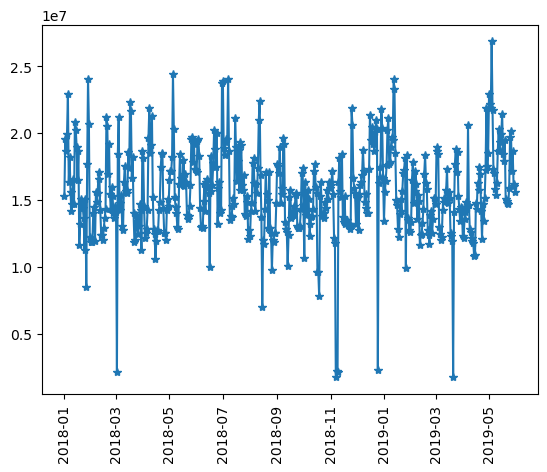

In [162]:
# Lets take a look at our time series plot
plt.plot(df_train_time_1.index, df_train_time_1['Sales'], '-*')
plt.xticks(rotation = 90)
plt.show()

<Figure size 640x480 with 0 Axes>

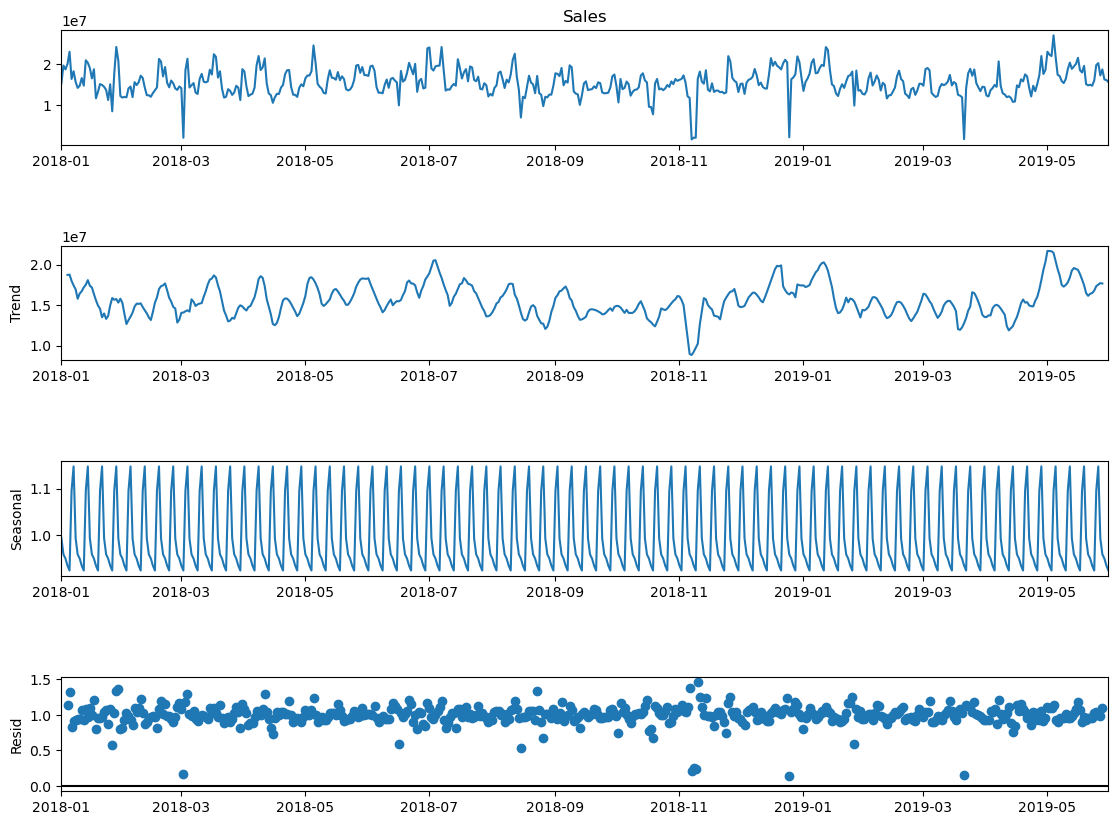

In [163]:
# Now let's try to decompose the time series to see if it follows any pattern**
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_train_time_1['Sales'], model = 'multiplicative')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
fig.show()

In [164]:
train = df_train_time_1.iloc[:413]
test = df_train_time_1.iloc[413:]

In [165]:
model = SARIMAX(train['Sales'],seasonal_order=(1,0,1,7))
results = model.fit()
fc = results.forecast(42)

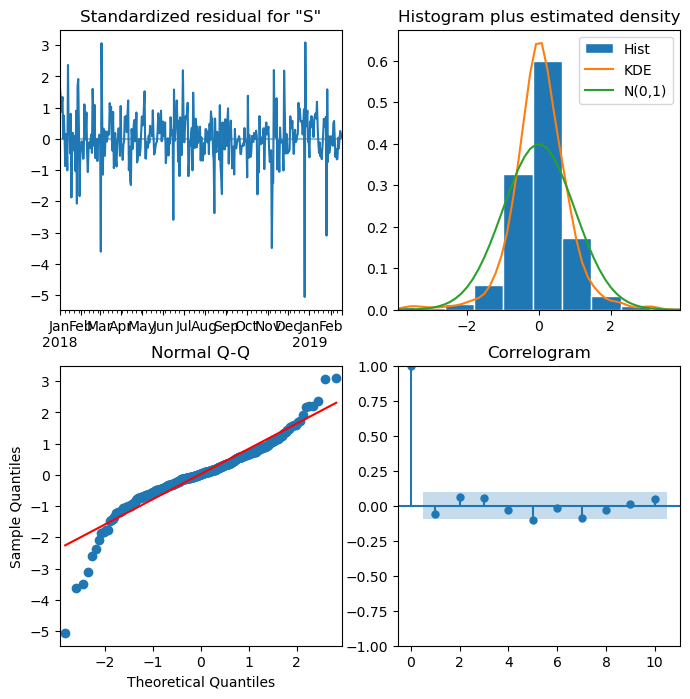

In [166]:
# Let's analyze the residuals after training the model on the SARIMA
results.plot_diagnostics(figsize=(8,8));

In [167]:
# Obtain predicted values
start = len(train)
end = len(train) + len(test)-1
predictions = results.predict(start = start, end = end)

In [168]:
# Let's create performance Function -
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape

)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

MAE : 2338402.885
RMSE : 3167315.413
MAPE: 0.206


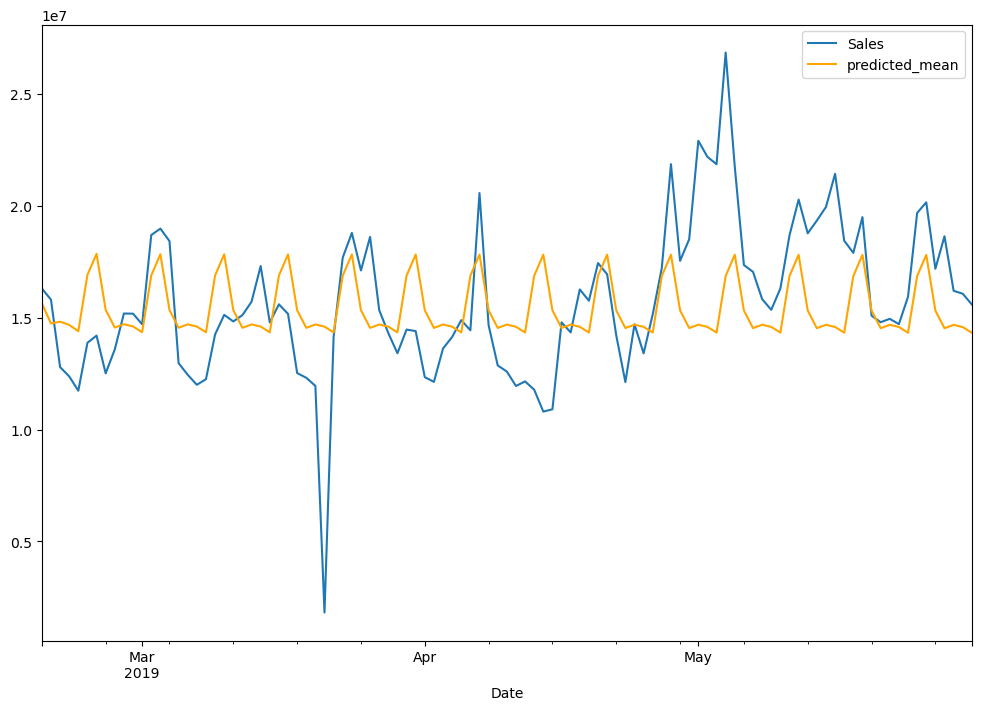

In [143]:
performance(test['Sales'], predictions)
# Plot predictions against known values

ax = test['Sales'].plot(legend = True, figsize = (12,8))
predictions.plot(legend = True, color = 'orange')
ax.autoscale(axis = 'x',tight = True)
# ax.set(xlabel=xlabel, ylabel=ylabel)
# for x in test.query('holiday==1').index:
#     ax.axvline(x=x, color='red', alpha = 0.5)

MAE : 2356189.807
RMSE : 3318400.734
MAPE: 0.194


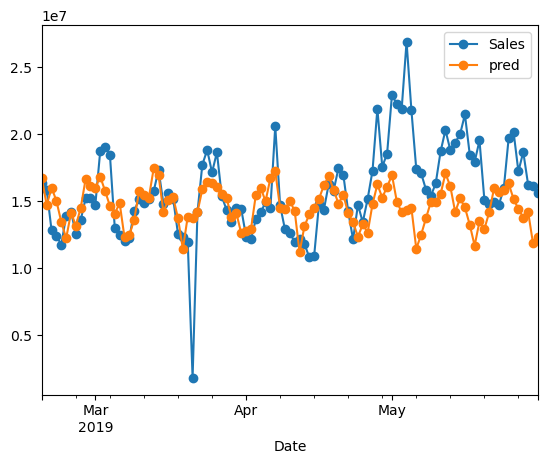

In [169]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train.Sales, order = (3, 1, 3), seasonal_order = (1,1,1,12))
model = model.fit()
test['pred'] = model.forecast(steps = 103)
test.plot(style='-o')
performance(test['Sales'], test['pred'])

    Comments -
    
        As we can see SARIMAX Model is not giving better results as compared to Previous XGBoost models, 
        
        so we will use results of XGBoost only.
        